In [1]:
%cd ..

/home/zarizky/projects/neural-autoregressive-object-co-occurrence


In [2]:
from copy import deepcopy
from math import log

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
from tqdm.auto import tqdm

from EinsumNetwork import EinsumNetwork, Graph
from utils import mutual_information
from utils.dataset import ObjectCooccurrenceCOCODataset

torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
dataset_train = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-train.csv")
dataset_valid = ObjectCooccurrenceCOCODataset("dataset/coco2017-cooccurences-valid.csv")

batch_size = 8196
dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size,
    True,
    drop_last=True,
    num_workers=8,
    pin_memory=device == "cuda",
)
dataloader_train2 = torch.utils.data.DataLoader(
    dataset_train, batch_size, num_workers=8, pin_memory=device == "cuda"
)
dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid, batch_size, num_workers=8, pin_memory=device == "cuda"
)

In [4]:
max_num_epochs = 500
online_em_frequency = 1
online_em_stepsize = 1e-3
if dataloader_train.drop_last:
    online_em_stepsize = 1 / len(dataloader_train)

In [5]:
data_train = torch.from_numpy(dataset_train.features.to_numpy()).to(device)
mi = mutual_information(data_train).cpu()
pair1, pair2 = torch.where(mi != -torch.inf)
mi_pairs = []
for i, j in zip(pair1, pair2):
    mi_pairs.append(dict(i=i.item(), j=j.item(), value=mi[i, j].item()))
mi_pairs = sorted(mi_pairs, key=lambda k: k["value"], reverse=True)

In [6]:
def pairwise_region_graph(k, pairs, replica_id):
    G = nx.DiGraph()

    G_pair = nx.DiGraph()

    root = Graph.DistributionVector([0, 1])
    root_pair = Graph.DistributionVector(pairs)

    for i in range(k):
        product = Graph.Product([0, 1])
        left = Graph.DistributionVector([0])
        right = Graph.DistributionVector([1])

        left.einet_address.replica_idx = i
        right.einet_address.replica_idx = i

        G.add_edge(product, left)
        G.add_edge(product, right)
        G.add_edge(root, product)

        product_pair = Graph.Product(pairs)
        left_pair = Graph.DistributionVector([pairs[0]])
        right_pair = Graph.DistributionVector([pairs[0]])

        left_pair.einet_address.replica_idx = replica_id[0]
        right_pair.einet_address.replica_idx = replica_id[0]

        G_pair.add_edge(product_pair, left_pair)
        G_pair.add_edge(product_pair, right_pair)
        G_pair.add_edge(root_pair, product_pair)

        replica_id[0] += 1

    return G, G_pair, root_pair


def pairwise_einet(k, pairs, replica_id, **kwargs):
    graph, graph_pair, root_pair = pairwise_region_graph(k, pairs, replica_id)

    args = EinsumNetwork.Args(
        num_classes=1,
        num_input_distributions=1,
        exponential_family=EinsumNetwork.CategoricalArray,
        exponential_family_args={"K": 29},
        num_sums=1,
        num_var=2,
        **kwargs
        # online_em_frequency=online_em_frequency,
        # online_em_stepsize=online_em_stepsize,
    )

    einet = EinsumNetwork.EinsumNetwork(graph, args)
    einet.initialize()

    return einet, graph_pair, root_pair


def bic_score(log_likelihood, sample_size, param_size):
    return log_likelihood - param_size / 2 * log(sample_size)

In [7]:
def lcm(
    pairs,
    trainloader,
    evalloader,
    k_max,
    epochs_max,
    patience_max,
    device,
    replica_id=[0],
    **kwargs
):
    bic_best = -torch.inf
    for k in range(k_max):
        model, graph, root = pairwise_einet(k + 1, pairs, replica_id, **kwargs)
        model = model.to(device)

        p_total = sum(p.numel() for p in model.parameters())

        ll_best = -torch.inf
        patience = 1
        for epoch in range(epochs_max):
            for inputs in trainloader:
                inputs = inputs.to(device)[:, pairs]
                outputs = model(inputs)

                ll = EinsumNetwork.log_likelihoods(outputs).sum()
                ll.backward()
                model.em_process_batch()
                model.em_update()
                model.zero_grad()

            with torch.inference_mode():
                ll_total = 0
                n_total = 0
                for inputs in evalloader:
                    inputs = inputs.to(device)[:, pairs]
                    outputs = model(inputs)

                    ll = EinsumNetwork.log_likelihoods(outputs).sum()
                    ll_total = ll_total + ll.item()
                    n_total = n_total + inputs.size(0)

            if ll_total > ll_best:
                patience = 1
                ll_best = ll_total
            else:
                patience = patience + 1

            if patience > patience_max:
                break

        bic = bic_score(ll_total, n_total, p_total)

        if bic > bic_best:
            print(k + 1, bic, ll_total, p_total)
            bic_best = bic
            k_best = k + 1
            graph_best = graph
            root_best = root
        else:
            break

    return k_best, graph_best, root_best

In [ ]:
k_max = 20
epochs_max = 100
patience_max = 5

In [10]:
V = set(range(dataset_train.features.shape[1]))

G = nx.DiGraph()

for pair in mi_pairs[:2]:
    # Greedily fetch W sorted by highest MI
    i, j, score = pair.values()

    # Remove W from V
    V.discard(i)
    V.discard(j)

    print(dataset_train.features.columns[i], dataset_train.features.columns[j])

    # Do LCM(W)
    k, g, r = lcm(
        (i, j),
        dataloader_train,
        dataloader_train2,
        k_max,
        epochs_max,
        patience_max,
        device,
        online_em_frequency=online_em_frequency,
        online_em_stepsize=online_em_stepsize,
    )
    
    # Check single state
    if k <= 1:
        break
        
    
        
    # Stop if no variable remains
    if len(V) <= 0:
        break
        
    

    G = nx.compose(G, g)

[dining table]-[furniture] [chair]-[furniture]
1 -110461.66913613139 -110117.08349609375 59
2 -105076.06992266659 -104375.2177734375 120
[dining table]-[furniture] [cup]-[kitchen]
1 -92749.76068886576 -92405.17504882812 59
2 -87218.44492266659 -86517.5927734375 120


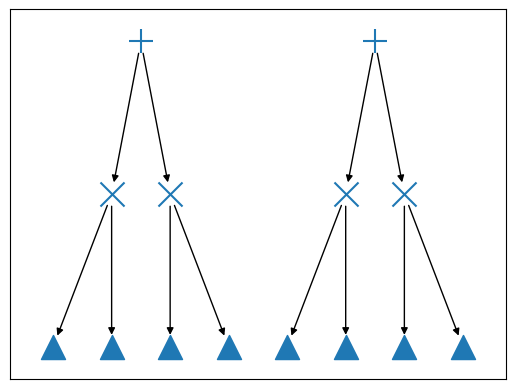

In [13]:
pos = nx.nx_agraph.graphviz_layout(G, "dot")

products = Graph.get_products(G)
leaves = Graph.get_leaves(G)
sums = Graph.get_sums(G)

nx.draw_networkx_nodes(G, pos, leaves, node_shape="^")
nx.draw_networkx_nodes(G, pos, products, node_shape="x")
nx.draw_networkx_nodes(G, pos, sums, node_shape="+")
nx.draw_networkx_edges(G, pos)

plt.show()